In [2]:
import pickle

import jax
import jax.numpy as jnp
from functools import partial

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

import StreaMAX as smx

In [57]:
halo_dict = {
    'logM': 11.64,
    'Rs':16.,
    'a':1.0,
    'b':1.0,
    'c':1.0,
    'x_origin':0.0,
    'y_origin':0.0,
    'z_origin':0.0,
    'dirx':0.0,
    'diry':0.0,
    'dirz':1.0
}

disc_dict = {
    'logM': 10.84,
    'Rs': 3.0,
    'Hs': 0.28,
    'x_origin': 0.0,
    'y_origin': 0.0,
    'z_origin': 0.0,
    'dirx': 0.0,
    'diry': 0.0,
    'dirz': 1.0
}

bar_dict = {
    'A': jnp.fabs(smx.potentials.MiyamotoNagai_potential(0, 0, 0, disc_dict)),
    'Rs': 4.0,
    'Hs': 0.5,
    'Omega': 35.0,
    't0': 0.5,
    't1': 1.5,
    'x_origin': 0.0,
    'y_origin': 0.0,
    'z_origin': 0.0,
    'dirx': 0.0,
    'diry': 0.0,
    'dirz': 1.0
}

@jax.jit
def acc_fn(x, y, z, t, halo_dict, disc_dict, bar_dict):
    a_halo = smx.potentials.NFW_acceleration(x, y, z, halo_dict)
    a_disk = smx.potentials.MiyamotoNagai_acceleration(x, y, z, disc_dict)
    a_bar  = smx.potentials.Bar_acceleration(x, y, z, t, bar_dict)
    return a_halo + a_disk + a_bar

with open('./ic_thin_1015.pickle', 'rb') as f:
    ic = pickle.load(f)
w0 = jnp.array([ic['x'], ic['y'], ic['z'], ic['vx'], ic['vy'], ic['vz']]).T

n_particles = 100000
w0 = w0[:n_particles]
time = 4.
n_steps = 1000
dt = time / n_steps
unroll = False

In [ ]:
def _split(w):
    return w[:3], w[3:]

def _merge(r, v):
    return jnp.concatenate([r, v], axis=0)

@partial(jax.jit, static_argnames=('acc_fn', 'n_steps', 'unroll'))
def integrate_leapfrog_traj(w0, params_halo, params_disk, params_bar, acc_fn, n_steps, dt = 0.010, t0 = 0.0, unroll=True):
    """Leapfrog (KDK) — returns final time and final state only."""

    def step(carry, _):
        t, y = carry
        r, v = _split(y)
        a0 = acc_fn(*r, t, params_halo, params_disk, params_bar)
        v_half = v + 0.5 * dt * a0
        r_new = r + dt * v_half
        t_new = t + dt
        a1 = acc_fn(*r_new, t_new, params_halo, params_disk, params_bar)
        v_new = v_half + 0.5 * dt * a1
        y_new = _merge(r_new, v_new)
        return (t_new, y_new), (t_new, y_new)

    (_, _), (tN, wN) = jax.lax.scan(step, (t0, w0), xs=None, length=n_steps, unroll=unroll)
    return tN, wN

In [59]:
t_all, xv_all = jax.vmap(integrate_leapfrog_traj, in_axes=(0, None, None, None, None, None, None, None, None)) \
                                        (w0, halo_dict, disc_dict, bar_dict, acc_fn, n_steps, dt, 0., False)

In [2]:
# arg_take = jnp.where((t_all[0]- bar_dict['t1']) > 0.)[0]

# t_in = t_all[:, arg_take]
# xv_in = xv_all[:, arg_take]

# angles = -t_all[:, arg_take] * bar_dict['Omega']

@jax.jit
def bar_frame(xv, angle):
    # Rotate contourclockwise with positive angle
    sina, cosa = jnp.sin(angle), jnp.cos(angle)
    xv = xv.at[:,0].set(xv[:,0]*cosa-xv[:,1]*sina)
    xv = xv.at[:,1].set(xv[:,0]*sina+xv[:,1]*cosa)
    xv = xv.at[:,3].set(xv[:,3]*cosa-xv[:,4]*sina)
    xv = xv.at[:,4].set(xv[:,3]*sina+xv[:,4]*cosa)
    return xv

angles = -t_all * bar_dict['Omega']
xv_bar_ref = jax.vmap(jax.vmap(bar_frame, in_axes=(0,0)), in_axes=(0,0))(xv_all, angles)

NameError: name 'jax' is not defined

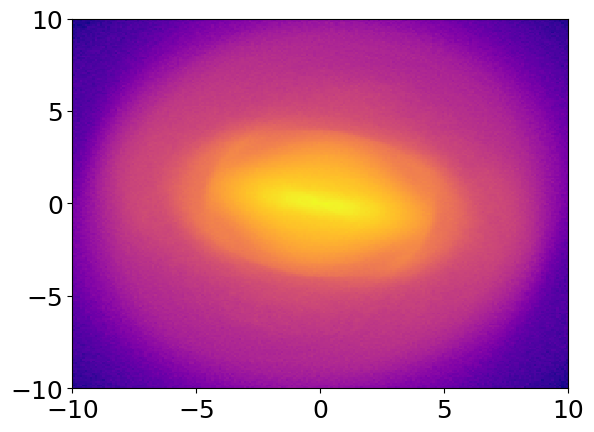

In [61]:
plt.hist2d(xv_bar_ref[:,:,0].flatten(), xv_bar_ref[:,:,1].flatten(), bins=200, range=[[-10,10],[-10,10]], density=True, cmap='plasma', norm='log');

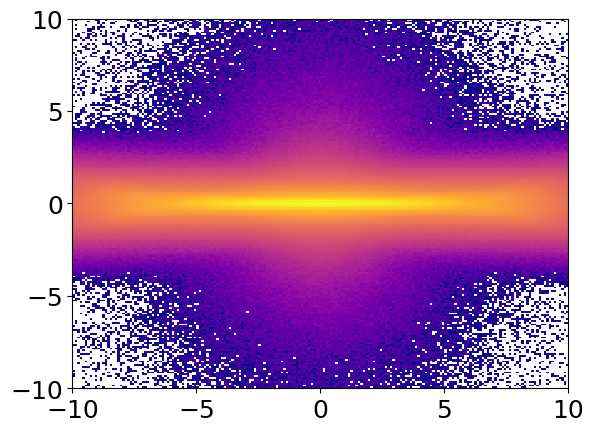

In [62]:
plt.hist2d(xv_bar_ref[:,:,0].flatten(), xv_bar_ref[:,:,2].flatten(), bins=200, range=[[-10,10],[-10,10]], density=True, cmap='plasma', norm='log');

In [63]:
with open('./ic_thick_1015.pickle', 'rb') as f:
    ic = pickle.load(f)
w0_thick = jnp.array([ic['x'], ic['y'], ic['z'], ic['vx'], ic['vy'], ic['vz']]).T

n_thick_particles = 10000
w0_thick = w0_thick[:n_thick_particles]

t_guess, xv_guess = jax.vmap(integrate_leapfrog_traj, in_axes=(0, None, None, None, None, None, None, None, None)) \
                                        (w0_thick, halo_dict, disc_dict, bar_dict, acc_fn, n_steps, dt, 0., False)

In [64]:
arg_take_guess = jnp.where((t_guess[0]- bar_dict['t1']) > 0.)[0]

t_guess_in = t_guess[:, arg_take_guess]
xv_guess_in = xv_guess[:, arg_take_guess]

angles_guess = -t_guess[:, arg_take_guess] * bar_dict['Omega']

@jax.jit
def bar_frame(x, y, z, vx, vy, vz, angle):
    # Rotate contourclockwise with positive angle
    sina, cosa = jnp.sin(angle), jnp.cos(angle)
    return jnp.array([x*cosa-y*sina, x*sina+y*cosa, z, vx*cosa-vy*sina, vx*sina+vy*cosa, vz]).T

xv_bar_ref_guess = jax.vmap(bar_frame, in_axes=(0,0,0,0,0,0,0))(xv_guess_in[:,:,0], xv_guess_in[:,:,1], xv_guess_in[:,:,2], xv_guess_in[:,:,3], xv_guess_in[:,:,4], xv_guess_in[:,:,5], angles_guess)

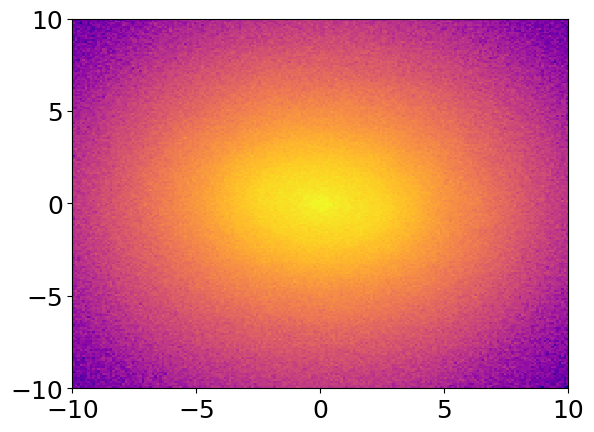

In [66]:
plt.hist2d(xv_bar_ref_guess[:,:,0].flatten(), xv_bar_ref_guess[:,:,1].flatten(), bins=200, range=[[-10,10],[-10,10]], density=True, cmap='plasma', norm='log');

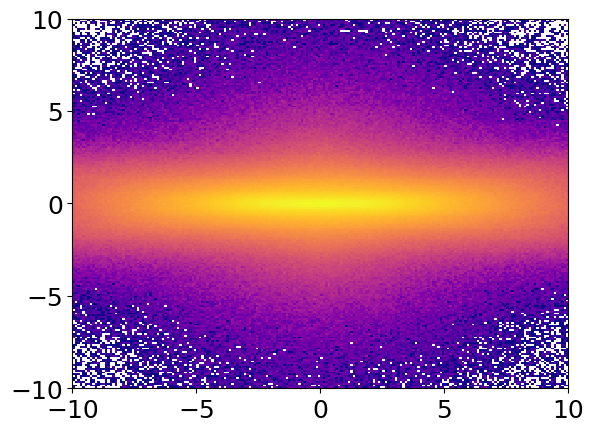

In [67]:
plt.hist2d(xv_bar_ref_guess[:,:,0].flatten(), xv_bar_ref_guess[:,:,2].flatten(), bins=200, range=[[-10,10],[-10,10]], density=True, cmap='plasma', norm='log');

## Ok, time to fight the weights in 3D

In [77]:
xlim = [-10, 10]
ylim = [-10, 10]
zlim = [-5, 5]

# Bin the positions in 3D using numpy.histogramdd
bins = [
    np.arange(xlim[0], xlim[1] + 0.5, 0.5),
    np.arange(ylim[0], ylim[1] + 0.5, 0.5),
    np.arange(zlim[0], zlim[1] + 0.5, 0.5)
]

positions = np.stack([
    xv_bar_ref[:,:,0].flatten(),
    xv_bar_ref[:,:,1].flatten(),
    xv_bar_ref[:,:,2].flatten()
], axis=1)

hist3d, edges = np.histogramdd(positions, bins=bins)

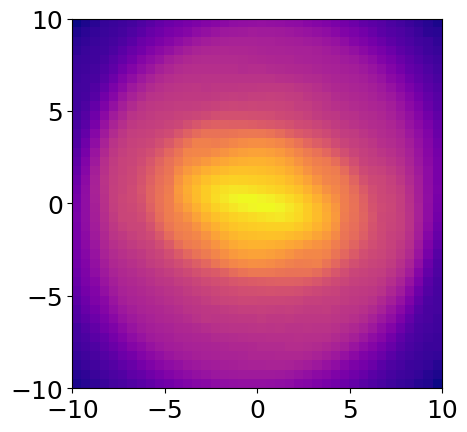

In [78]:
plt.imshow(np.log10(hist3d.sum(axis=2).T + 1), origin='lower', extent=[xlim[0], xlim[1], ylim[0], ylim[1]], cmap='plasma');

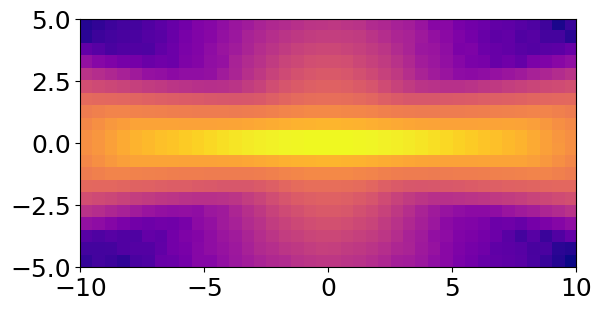

In [79]:
plt.imshow(np.log10(hist3d.sum(axis=1).T + 1), origin='lower', extent=[xlim[0], xlim[1], zlim[0], zlim[1]], cmap='plasma');

# Trying to get Phi_m

In [52]:
from CylindricalSpline import *
from densities import *
from potentials import *
import time as tt

import matplotlib.pyplot as plt

In [66]:
rho_fn = MiyamotoNagai_density
params = {
    'logM': 9.,
    'a': 3.,
    'b': 0.8,
    'x_origin': 0.,
    'y_origin': 0.,
    'z_origin': 0.,
    'dirx': 0.,
    'diry': 0.,
    'dirz': 1.,
}

NR, NZ, Rmin, Rmax, Zmin, Zmax, Mmax = 50, 30, 1e-2, 30.0, 1e-2, 20.0, 0.
Nphi = 200
N_int = 10_000

a = tt.time()
pot_data = get_phi_m(rho_fn, params, NR, NZ, Rmin, Rmax, Zmin, Zmax, Mmax, Nphi, N_int)
b = tt.time()
print(f'Time to get Phi_m: {(b-a)*1000:.2f} ms')

Time to get Phi_m: 2.33 ms


In [79]:
rho_fn = DoubleExponentialDiskx2FerrersBar_density
params = {
    'Sigma0_thin': 1.,
    'Rd_thin': 3.,
    'hz_thin': 0.2,
    'x_origin_thin': 0.,
    'y_origin_thin': 0.,
    'z_origin_thin': 0.,
    'dirx_thin': 0.,
    'diry_thin': 0.,
    'dirz_thin': 1.,

    'Sigma0_thick': 1.,
    'Rd_thick': 1.8,
    'hz_thick': 0.8,
    'x_origin_thick': 0.,
    'y_origin_thick': 0.,
    'z_origin_thick': 0.,
    'dirx_thick': 0.,
    'diry_thick': 0.,
    'dirz_thick': 1.,

    'a_bar': 4.,
    'b_bar': 1.5,
    'c_bar': 0.8,
    'rho0_bar': 1.,
    'n_bar': 2.,
    'phi_bar_deg': jnp.deg2rad(25.0),
    'x_origin': 0.,
    'y_origin': 0.,
    'z_origin': 0.,
    'dirx': 0.,
    'diry': 0.,
    'dirz': 1.,
}

NR, NZ, Rmin, Rmax, Zmin, Zmax, Mmax = 50, 30, 1e-2, 30.0, 1e-2, 20.0, 8.
Nphi = 200
N_int = 10_000

a = tt.time()
pot_data = get_phi_m(rho_fn, params, NR, NZ, Rmin, Rmax, Zmin, Zmax, Mmax, Nphi, N_int)
b = tt.time()
print(f'Time to get Phi_m: {(b-a)*1000:.2f} ms')

Time to get Phi_m: 5.62 ms


In [80]:
nx = 100
x = np.linspace(-10, 10, nx)
y = np.linspace(-10, 10, nx)
z = np.linspace(-0.5, 0.5, nx)
X, Y, Z = np.meshgrid(x, y, z)
dZ = Z[1] - Z[0]

gt_densities = jax.vmap(rho_fn, in_axes=(0, 0, 0, None))(X, Y, Z, params)

potential = jax.vmap(evaluate_phi, in_axes=(0, 0, 0, None))(X, Y, Z, pot_data)
acceleration = jax.vmap(get_acc, in_axes=(0, 0, 0, None))(X.ravel(),Y.ravel(),Z.ravel(), pot_data).reshape((3, nx, nx, nx))
hessians = jax.vmap(get_hessian, in_axes=(0, 0, 0, None))(X.ravel(),Y.ravel(),Z.ravel(), pot_data).reshape((9, nx, nx, nx))
densities = jax.vmap(get_density, in_axes=(0, 0, 0, None))(X.ravel(),Y.ravel(),Z.ravel(), pot_data).reshape((nx, nx, nx))

(np.float64(-0.5), np.float64(99.5), np.float64(-0.5), np.float64(99.5))

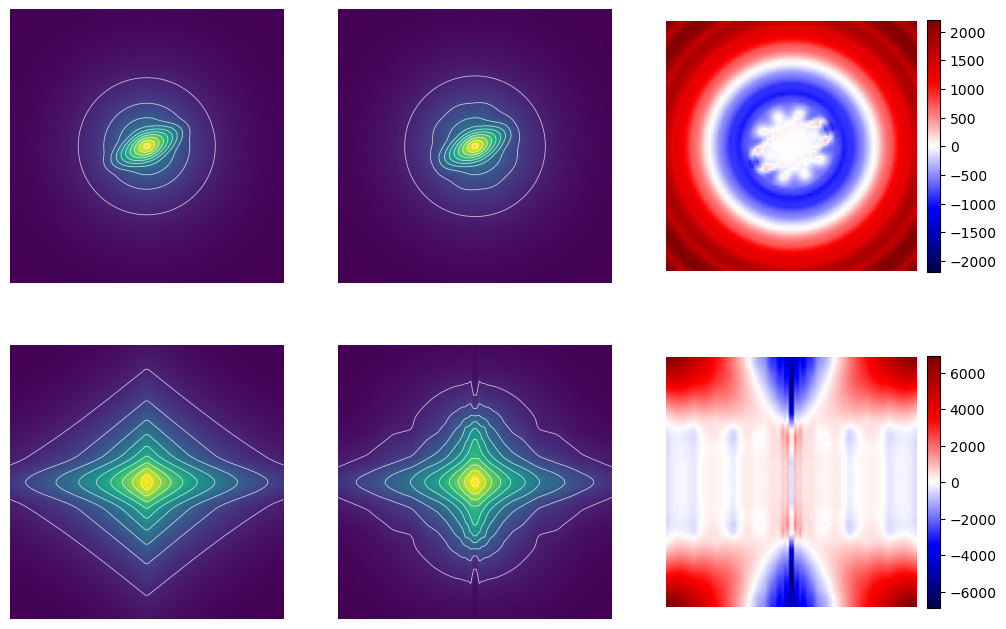

In [83]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.imshow(jnp.sum(gt_densities, axis=2), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
plt.contour(
    X[:, :, 0], Y[:, :, 0], jnp.sum(gt_densities, axis=2),
    levels=10,
    colors="white",
    linewidths=0.6,
    alpha=0.7,
)
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(jnp.sum(densities, axis=2), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
plt.contour(
    X[:, :, 0], Y[:, :, 0], jnp.sum(densities, axis=2),
    levels=10,
    colors="white",
    linewidths=0.6,
    alpha=0.7,
)
plt.axis('off')
plt.subplot(2,3,3)
res = jnp.sum(100*(densities-gt_densities)/gt_densities, axis=2)
mm = jnp.max(abs(res))
plt.imshow(res, origin='lower', cmap='seismic', vmin=-mm, vmax=mm)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(jnp.sum(gt_densities, axis=1), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
plt.contour(
    X[:, :, 0], Y[:, :, 0], jnp.sum(gt_densities, axis=1),
    levels=10,
    colors="white",
    linewidths=0.6,
    alpha=0.7,
)
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(jnp.sum(densities, axis=1), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
plt.contour(
    X[:, :, 0], Y[:, :, 0], jnp.sum(densities, axis=1),
    levels=10,
    colors="white",
    linewidths=0.6,
    alpha=0.7,
)
plt.axis('off')
plt.subplot(2,3,6)
res = jnp.sum(100*(densities-gt_densities)/gt_densities, axis=1)
mm = jnp.max(abs(res))
plt.imshow(jnp.sum(100*(densities-gt_densities)/gt_densities, axis=1), origin='lower', cmap='seismic', vmin=-mm, vmax=mm)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')


## Plots to check if correct

In [38]:
@jax.jit
def jax_phi_m_eval(m, x, y, z, Rgrid, Zgrid, rho_real, rho_img, Mx_real, My_real, Mx_img, My_img):

    R, ph = jnp.sqrt(x*x + y*y), jnp.arctan2(y, x)
    real_values = rho_real[m]
    imag_values = rho_img[m]
    M_x_real = Mx_real[m]
    M_y_real = My_real[m]
    M_x_imag = Mx_img[m]
    M_y_imag = My_img[m]

    shape = R.shape
    pts = jnp.column_stack((R.ravel(), jnp.abs(z).ravel()))

    real_part = cubic_spline_evaluate(pts, (Rgrid, Zgrid), real_values, M_x_real, M_y_real, fill_value=0.0).reshape(shape)
    imag_part = cubic_spline_evaluate(pts, (Rgrid, Zgrid), imag_values, M_x_imag, M_y_imag, fill_value=0.0).reshape(shape)

    phi_m = real_part + 1j * imag_part

    val = (phi_m.real * jnp.cos(m*ph) - phi_m.imag * jnp.sin(m*ph))

    val_final = jax.lax.cond(m==0, lambda: val, lambda: val*2)

    return val_final

def get_pot_from_coord(x,y,z):
    phi_grid = jax.vmap(jax_phi_m_eval, in_axes=(0, None, None, None, None, None, None, None, None, None, None, None))(
        M.astype(int), x, y, z, R, Z_nonneg, phi_real, phi_img, phi_Mx_real, phi_My_real, phi_Mx_img, phi_My_img)
    return jnp.sum(phi_grid, axis=0)

R = pot_data['Rgrid']
Z_nonneg = pot_data['Zgrid']
M = pot_data['m']
phi_real = pot_data['Phi_m_real']
phi_img = pot_data['Phi_m_img']
phi_Mx_real = pot_data['Mx_real']
phi_My_real = pot_data['My_real']
phi_Mx_img = pot_data['Mx_img']
phi_My_img = pot_data['My_img']

def rho_gt(x, y, z):
    return DoubleExponentialDiskx2FerrersBar_density(x, y, z, params)

# --- Projected surface density maps: face-on (z=0) and side-on (y=0) ---

# Face-on: integrate along z, grid in (x, y)
nx = 100
x = np.linspace(-10, 10, nx)
y = np.linspace(-10, 10, nx)
X, Y = np.meshgrid(x, y)
Z = np.linspace(-0.5, 0.5, nx)
dZ = Z[1] - Z[0]
Y2 = np.linspace(-10, 10, nx)
Z2 = np.linspace(-10, 10, nx)
Yg, Zg = np.meshgrid(Y2, Z2)
X2 = np.linspace(-10, 10, nx)
# X2 = np.array([-0.1,0.1])#np.linspace(-10, 10, nx)
dX = X2[1] - X2[0]

def rho_input(x):
    return np.array(rho_gt(x[:,0], x[:,1], x[:,2]))

In [ ]:
# FACE-ON view
Potential_faceon = np.zeros_like(X)

for i in tqdm(range(len(Z)), desc="Face-on integration"):
    z_slice = Z[i]
    Potential_faceon += (
        get_pot_from_coord(X, Y, np.full_like(X, z_slice)) * dZ
    )


# SIDE-ON view
Potential_sideon = np.zeros_like(Yg)

for i in tqdm(range(len(X2)), desc="Side-on integration"):
    x_slice = X2[i]
    Potential_sideon += (
        get_pot_from_coord(np.full_like(Yg, x_slice), Yg, Zg) * dX
    )

In [ ]:
pot_agama = agama.Potential(type='Cylspline', density=rho_input, gridSizeR=30, rmin=1e-2, rmax=20,zmin=1e-2, zmax=15,
                    symmetry = 'none', mmax=7)


Potential_agama_faceon = np.zeros_like(X)
for i in tqdm(range(len(Z))):

    z_slice = Z[i]
    # r, th, ph = cart_to_sph(np.full_like(Yg, x_slice), Yg, Zg)
    points = np.column_stack((X.ravel(), Y.ravel(), np.full_like(X.ravel(), z_slice)))
    Potential_agama_faceon += (pot_agama.potential(points) * dZ).reshape(X.shape)

Potential_fit_faceon = np.zeros_like(X)
for i in tqdm(range(len(Z))):
    z_slice = Z[i]
    Potential_fit_faceon += (get_pot_from_coord(X, Y, np.full_like(X, z_slice)) * dZ)


Potential_agama_sideon = np.zeros_like(Yg)
for i in tqdm(range(len(X2))):
    x_slice = X2[i]
    # r, th, ph = cart_to_sph(np.full_like(Yg, x_slice), Yg, Zg)
    points = np.column_stack((np.full_like(Yg.ravel(), x_slice), Yg.ravel(), Zg.ravel()))
    Potential_agama_sideon += (pot_agama.potential(points) * dX).reshape(Yg.shape)

Potential_fit_sideon = np.zeros_like(Yg)
for i in tqdm(range(len(X2))):
    x_slice = X2[i]
    Potential_fit_sideon += (get_pot_from_coord(np.full_like(Yg, x_slice), Yg, Zg) * dX)

# Residual (side-on)
Potential_residual_faceon = Potential_fit_faceon - Potential_agama_faceon
Potential_residual_sideon = Potential_fit_sideon - Potential_agama_sideon

# --- Plotting ---
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Face-on
im0 = axs[0, 0].imshow(-Potential_agama_faceon, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis',
)
axs[0, 0].set_title('Face-on: AGAMA potential')
plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)

im1 = axs[0, 1].imshow(-Potential_fit_faceon, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis',
)
axs[0, 1].set_title('Face-on: Fitted Potential')
plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

im2 = axs[0, 2].imshow(Potential_residual_faceon/Potential_agama_faceon, origin='lower', 
extent=[x.min(), x.max(), y.min(), y.max()], cmap='coolwarm', vmin=-0.1, vmax=0.1)
axs[0, 2].set_title('Face-on: Residual (Fit - Truth)')
plt.colorbar(im2, ax=axs[0, 2], fraction=0.046, pad=0.04)

for ax in axs[0, :]:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

# Side-on
im3 = axs[1, 0].imshow(-Potential_agama_sideon, origin='lower', extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()], cmap='viridis',
)
axs[1, 0].set_title('Side-on: AGAMA Potential')
plt.colorbar(im3, ax=axs[1, 0], fraction=0.046, pad=0.04)

im4 = axs[1, 1].imshow(-Potential_fit_sideon, origin='lower', extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()], cmap='viridis',
)
axs[1, 1].set_title('Side-on: Fitted Potential')
plt.colorbar(im4, ax=axs[1, 1], fraction=0.046, pad=0.04)

im5 = axs[1, 2].imshow(Potential_residual_sideon/Potential_agama_sideon, origin='lower',
extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()], cmap='coolwarm', vmin=-0.1, vmax=0.1)
axs[1, 2].set_title('Side-on: Residual (Fit - Truth)')
plt.colorbar(im5, ax=axs[1, 2], fraction=0.046, pad=0.04)

for ax in axs[1, :]:
    ax.set_xlabel('y')
    ax.set_ylabel('z')

plt.tight_layout()
plt.show()

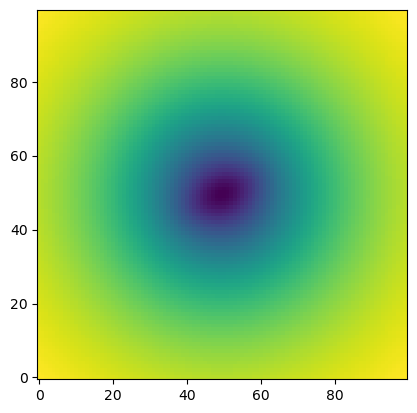

In [44]:
plt.imshow(Potential_faceon, origin='lower')

Side-on integration: 100%|██████████| 100/100 [00:00<00:00, 404.93it/s]


NameError: name 'Y2g' is not defined

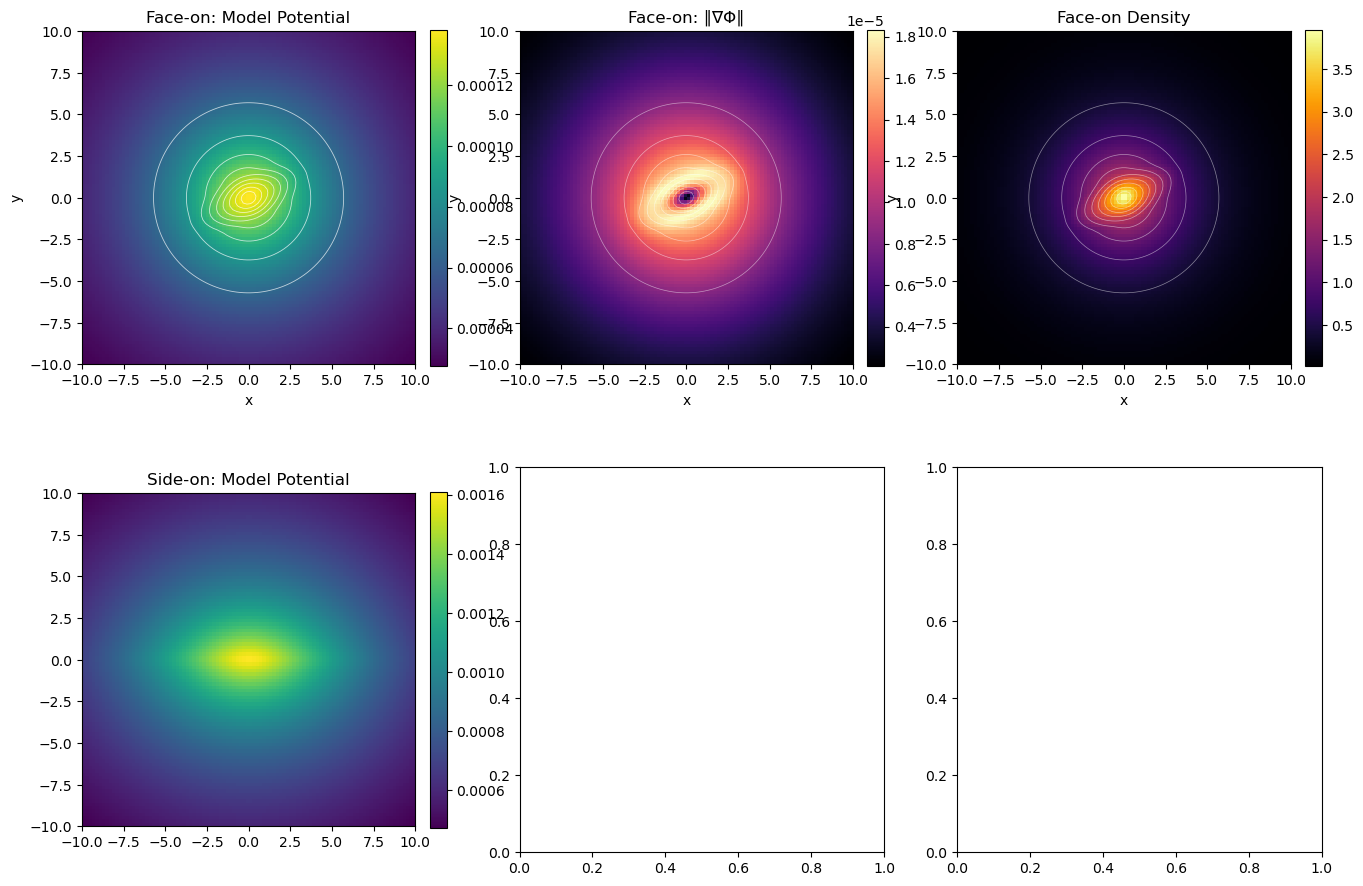

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------------------------------------
# Compute potentials from your model only (no AGAMA)
# -----------------------------------------------------------

# FACE-ON view
Potential_faceon = np.zeros_like(X)

for i in tqdm(range(len(Z)), desc="Face-on integration"):
    z_slice = Z[i]
    Potential_faceon += (
        get_pot_from_coord(X, Y, np.full_like(X, z_slice)) * dZ
    )


# SIDE-ON view
Potential_sideon = np.zeros_like(Yg)

for i in tqdm(range(len(X2)), desc="Side-on integration"):
    x_slice = X2[i]
    Potential_sideon += (
        get_pot_from_coord(np.full_like(Yg, x_slice), Yg, Zg) * dX
    )


# -----------------------------------------------------------
# Grid spacings for gradient
# -----------------------------------------------------------

dx = X[0, 1] - X[0, 0]
dy = Y[1, 0] - Y[0, 0]

dy2 = Y2[1] - Y2[0]
dz2 = Z2[1] - Z2[0]


# -----------------------------------------------------------
# Density slices for contour overlays
# -----------------------------------------------------------

# Face-on density: slice at z=0
rho_faceon = rho_fn(X, Y, np.zeros_like(X), params)

# Side-on density: slice at x=0
rho_sideon = rho_fn(np.zeros_like(Yg), Yg, Zg, params)


# -----------------------------------------------------------
# Gradients (optional visualization)
# -----------------------------------------------------------

dPhidx, dPhidy = np.gradient(Potential_faceon, dx, dy)
grad_faceon = np.sqrt(dPhidx**2 + dPhidy**2)

dPhidy2, dPhidz2 = np.gradient(Potential_sideon, dy2, dz2)
grad_sideon = np.sqrt(dPhidy2**2 + dPhidz2**2)


# -----------------------------------------------------------
# Plotting
# -----------------------------------------------------------

fig, axs = plt.subplots(2, 3, figsize=(16, 11))


# -----------------------------------------------------------
# 1. FACE-ON POTENTIAL
# -----------------------------------------------------------
im0 = axs[0, 0].imshow(
    -Potential_faceon,
    origin="lower",
    extent=[x.min(), x.max(), y.min(), y.max()],
    cmap="viridis",
)
axs[0, 0].set_title("Face-on: Model Potential")
plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)

# Density contours
axs[0, 0].contour(
    X, Y, rho_faceon,
    levels=10,
    colors="white",
    linewidths=0.6,
    alpha=0.7,
)


# -----------------------------------------------------------
# 2. FACE-ON GRADIENT MAGNITUDE
# -----------------------------------------------------------
im1 = axs[0, 1].imshow(
    grad_faceon,
    origin="lower",
    extent=[x.min(), x.max(), y.min(), y.max()],
    cmap="magma",
)
axs[0, 1].set_title("Face-on: ∥∇Φ∥")
plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

axs[0, 1].contour(
    X, Y, rho_faceon,
    levels=10,
    colors="white",
    linewidths=0.5,
    alpha=0.5,
)


# -----------------------------------------------------------
# 3. FACE-ON DENSITY MAP
# -----------------------------------------------------------
im2 = axs[0, 2].imshow(
    rho_faceon,
    origin="lower",
    extent=[x.min(), x.max(), y.min(), y.max()],
    cmap="inferno",
)
axs[0, 2].set_title("Face-on Density")
plt.colorbar(im2, ax=axs[0, 2], fraction=0.046, pad=0.04)

axs[0, 2].contour(
    X, Y, rho_faceon,
    levels=10,
    colors="white",
    linewidths=0.5,
    alpha=0.5,
)


for ax in axs[0, :]:
    ax.set_xlabel("x")
    ax.set_ylabel("y")


# -----------------------------------------------------------
# 4. SIDE-ON POTENTIAL
# -----------------------------------------------------------
im3 = axs[1, 0].imshow(
    -Potential_sideon,
    origin="lower",
    extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()],
    cmap="viridis",
)
axs[1, 0].set_title("Side-on: Model Potential")
plt.colorbar(im3, ax=axs[1, 0], fraction=0.046, pad=0.04)

axs[1, 0].contour(
    Y2g, Z2g, rho_sideon,
    levels=10,
    colors="white",
    linewidths=0.6,
    alpha=0.7,
)


# -----------------------------------------------------------
# 5. SIDE-ON GRADIENT MAGNITUDE
# -----------------------------------------------------------
im4 = axs[1, 1].imshow(
    grad_sideon,
    origin="lower",
    extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()],
    cmap="magma",
)
axs[1, 1].set_title("Side-on: ∥∇Φ∥")
plt.colorbar(im4, ax=axs[1, 1], fraction=0.046, pad=0.04)

axs[1, 1].contour(
    Y2g, Z2g, rho_sideon,
    levels=10,
    colors="white",
    linewidths=0.5,
    alpha=0.5,
)


# -----------------------------------------------------------
# 6. SIDE-ON DENSITY
# -----------------------------------------------------------
im5 = axs[1, 2].imshow(
    rho_sideon,
    origin="lower",
    extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()],
    cmap="inferno",
)
axs[1, 2].set_title("Side-on Density")
plt.colorbar(im5, ax=axs[1, 2], fraction=0.046, pad=0.04)

axs[1, 2].contour(
    Y2g, Z2g, rho_sideon,
    levels=10,
    colors="white",
    linewidths=0.5,
    alpha=0.5,
)


for ax in axs[1, :]:
    ax.set_xlabel("y")
    ax.set_ylabel("z")

plt.tight_layout()
plt.show()
